Мышковец С.А., v.1 06.03.2023

**Решение задачи:**

ДЗ - оценить возраст человека по изображению. 

Взять за основу любое предыдущее задание (если нет вычислительных ресурсов, то классификация заемщика, если есть, то классификация изображений или определение возраста, и реализовать стекинг несколькоих моделей). 

Требование: структуру моделе реализовать с использованием функций. 

Дополнительное требование (по возможности): структуру модели реализовать без использования последовательных API (через класс). Реализовать пользовательский цикл обучения. 
Фрэймворк выбора: на выбор учащегося. 

Основная задача ДЗ: отработать навыки самостоятельного написания моделей. 

**Вывод**

| Модель | train | valid | test |
| ----------- | ----------- | ----------- |----------- |
| model | 9,35 | 9,87 | 9,69 | 
| custom_model | 5,23 | 7,09 | 7,14 |
| vgg16_model | 4,37 | 6,29 | 6.34 |
| mobilenet_model | 3,48 | 6,66 | 6.50 |
| avg_model | 4,92 | 6,27 | 6,37 |
| model_conc | 3.49 | 6.15 | 6,18 |

К улучшению результата привела конкатенация моделей, давших примерно одинаковый результат при отдельном обучении.

Средний ансамбль моделей vgg16_model и mobilenet_model не улучшил результат модели vgg16_model.

Конкатенации моделей vgg16_model и mobilenet_model улучшила результат модели vgg16_model с 6.34 до 6.18.

Применение ансамбля моделей в примере ниже не оправдывает временные затраты. Скорее всего, при подборе параметров можно было повторить результат конкатенации на отдельной модели.

# Загрузим необходимые библиотеки и проведем разведовательный анализ данных.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


import sys
import os

OpenCV: 4.7.0
matplotlib: 3.6.3
graphviz: 0.20.1


In [ ]:
# Define loss visualization function
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

In [2]:
import os
main_dir = os.getcwd()

In [3]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/UTKFace"

In [4]:
# Extract age values from file names
age = []
for file in os.listdir(ImgLocation):
    file = int(file.split('_')[0])
    age.append(file)

In [5]:
len(age)

23708

In [6]:
# Extract paths for further data exploration
full_path = []
for file in os.listdir(ImgLocation):
    path = ImgLocation + '/' + file
    full_path.append(path)

In [8]:
# Create pd DataFrame
df = pd.DataFrame({'age': age,  
                   'full_path': full_path, 
                   }
                 )

In [9]:
df.head()

,age,full_path
0,9,/Users/sviatlanamyshkavets/Documents/Courses/D...
1,36,/Users/sviatlanamyshkavets/Documents/Courses/D...
2,86,/Users/sviatlanamyshkavets/Documents/Courses/D...
3,26,/Users/sviatlanamyshkavets/Documents/Courses/D...
4,1,/Users/sviatlanamyshkavets/Documents/Courses/D...


In [10]:
df.describe()

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23708 non-null  int64 
 1   full_path  23708 non-null  object
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


# Выведем фотографии из файлов, частично проверим верность целевых меток.

**При необходимости при помощи кода ниже пробежимся по папкам и проверим фото детей до 18 лет, удалим явные выбросы. В нашем случае выбран очищенный датасет.**

In [ ]:
test = df[df['age']==1]
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in test['full_path']:
#     img = cv2.imread(file)
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.xlabel(i)
    print(i)
    plt.show()

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

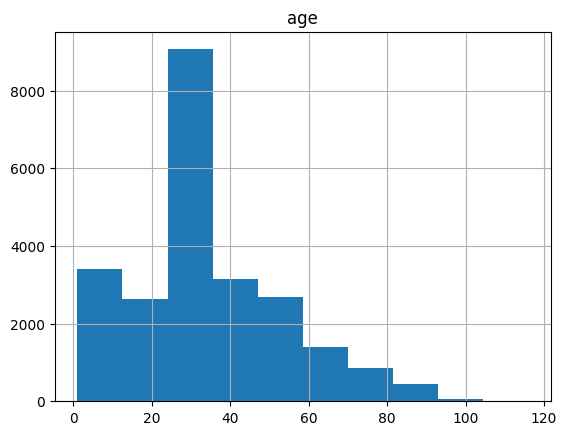

In [13]:
# Explore age distribution
df.hist()

In [14]:
df.groupby('age')['age'].count().sort_values()

age
111       1
103       1
101       2
91        2
115       3
       ... 
24      859
35      880
28      918
1      1123
26     2197
Name: age, Length: 104, dtype: int64

In [15]:
# Delete age values over 99 years
index_age_100 = df[df['age']>99].index
df.drop(index_age_100 , inplace=True)

In [15]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df['age'] = labelencoder.fit_transform(df['age'])

**Разделим данные на тренировочную, тестовую и валидационную выборку.**

In [16]:
from sklearn.model_selection import train_test_split

y = df['age']
X = df['full_path']

In [17]:
train_full, test= train_test_split(
    df, test_size=0.1, stratify=df['age'], random_state=0)

In [18]:
train_full.groupby('age')['age'].count()

age
1     1011
2      434
3      260
4      246
5      176
      ... 
92      12
93       5
95       8
96      15
99       8
Name: age, Length: 96, dtype: int64

In [21]:
train_full.shape

(21308, 2)

In [22]:
# Extract valid from train
train, valid = train_full[:-5500], train_full[-5500:]

In [40]:
test.shape

(2368, 2)

In [24]:
test.groupby('age')['age'].count()

age
1     112
2      48
3      29
4      27
5      20
     ... 
90      8
92      1
95      1
96      2
99      1
Name: age, Length: 94, dtype: int64

In [26]:
# Create necessary folders for image storage
os.makedirs('train')

In [27]:
os.makedirs('test')

In [28]:
os.makedirs('valid')

In [29]:
# Create lists for train/test/valid images
train_files = []
for i in train['full_path']:
    train_files.append(i)
for a in train['age']:
    train_files.append(a)

In [30]:
test_files = []
for i in test['full_path']:
    test_files.append(i)
for a in test['age']:
    test_files.append(a)

In [31]:
valid_files = []
for i in valid['full_path']:
    valid_files.append(i)
for a in valid['age']:
    valid_files.append(a)

In [33]:
train_dir = main_dir + '/train'
test_dir = main_dir + '/test'
valid_dir = main_dir + '/valid'

In [34]:
for filename in os.listdir(ImgLocation):
    if filename != '.DS_Store':
        # for i in os.listdir(ImgLocation + '/' + filename):
        file = ImgLocation + '/' + filename
        if file in train_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img]) # Some images are in  greyscale (1 channel), 
                                                     # therefore convert them to 3 channel
            path = train_dir
            cv2.imwrite(os.path.join(path, filename), img)
        if file in test_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            path = test_dir
            cv2.imwrite(os.path.join(path, filename), img)
        if file in valid_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            path = valid_dir
            cv2.imwrite(os.path.join(path, filename), img)

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
train_datagen=ImageDataGenerator(rescale=1./255.)

In [37]:
test_datagen=ImageDataGenerator(rescale=1./255.)

In [38]:
valid_datagen=ImageDataGenerator(rescale=1./255.)

In [41]:
TARGET_SIZE = (224,224)

train_gen=train_datagen.flow_from_dataframe(
dataframe=train,
directory=main_dir + '/train',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=TARGET_SIZE
)

valid_gen=train_datagen.flow_from_dataframe(
dataframe=valid,
directory=main_dir + '/valid',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=TARGET_SIZE
)

test_gen=test_datagen.flow_from_dataframe(
dataframe=test,
directory=main_dir + '/test',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
target_size=TARGET_SIZE
)

Found 15808 validated image filenames.
Found 5500 validated image filenames.
Found 2368 validated image filenames.


# Определим и обучим несколько моделей.

**Model**

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
          
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalMaxPool2D())

model.add(Dense(1000))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('linear'))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-20 11:11:48.357518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-20 11:11:48.358177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 64)      0

In [72]:
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mae'])

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

checkpoint_cb = ModelCheckpoint("ConvModel.h5", 
                                     monitor = "val_mae",
                                     save_best_only=True)

In [74]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    callbacks=[checkpoint_cb, lr_scheduler],
                    epochs=50)

Epoch 1/50


2023-04-20 11:12:09.583217: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-20 11:12:09.836178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - ETA: 0s - loss: 495.0218 - mae: 17.2035

2023-04-20 11:12:56.787538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - 57s 113ms/step - loss: 495.0218 - mae: 17.2035 - val_loss: 471.5973 - val_mae: 15.9296 - lr: 5.0000e-05
Epoch 2/50
494/494 [==============================] - 51s 103ms/step - loss: 415.8498 - mae: 15.8401 - val_loss: 397.6850 - val_mae: 15.3985 - lr: 5.0000e-05
Epoch 3/50
494/494 [==============================] - 51s 103ms/step - loss: 374.2493 - mae: 14.9884 - val_loss: 341.0019 - val_mae: 13.5589 - lr: 5.0000e-05
Epoch 4/50
494/494 [==============================] - 51s 104ms/step - loss: 305.8630 - mae: 13.4555 - val_loss: 286.2002 - val_mae: 12.3505 - lr: 5.0000e-05
Epoch 5/50
494/494 [==============================] - 51s 103ms/step - loss: 262.1138 - mae: 12.4599 - val_loss: 244.6866 - val_mae: 11.7437 - lr: 5.0000e-05
Epoch 6/50
494/494 [==============================] - 51s 103ms/step - loss: 234.5961 - mae: 11.8014 - val_loss: 223.2912 - val_mae: 11.3067 - lr: 5.0000e-05
Epoch 7/50
494/494 [==============================] - 51s 103ms

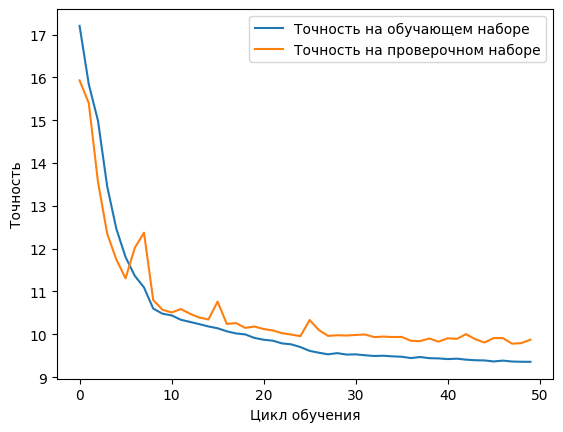

In [76]:
test_val_graph (history,'mae','val_mae')

In [77]:
model.evaluate (test_gen)

74/74 [==============================] - 2s 28ms/step - loss: 162.3588 - mae: 9.6984


[162.3588409423828, 9.698433876037598]

**Custom model**

In [42]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [375]:
target_size = (224,224,3) 
input = Input(shape= target_size) 

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=256, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 
x = GlobalMaxPool2D()(x)
x = Dropout(0.25)(x) 
x = Flatten()(x) 
x = Dense(units=128, activation='relu')(x) 
x = Dense(units=64, activation='relu')(x) 
output = Dense(units=1, activation='linear')(x) 

custom_model  = Model(input, output, name= 'Custom_Model')

In [376]:
custom_model.summary()

Model: "Custom_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)      

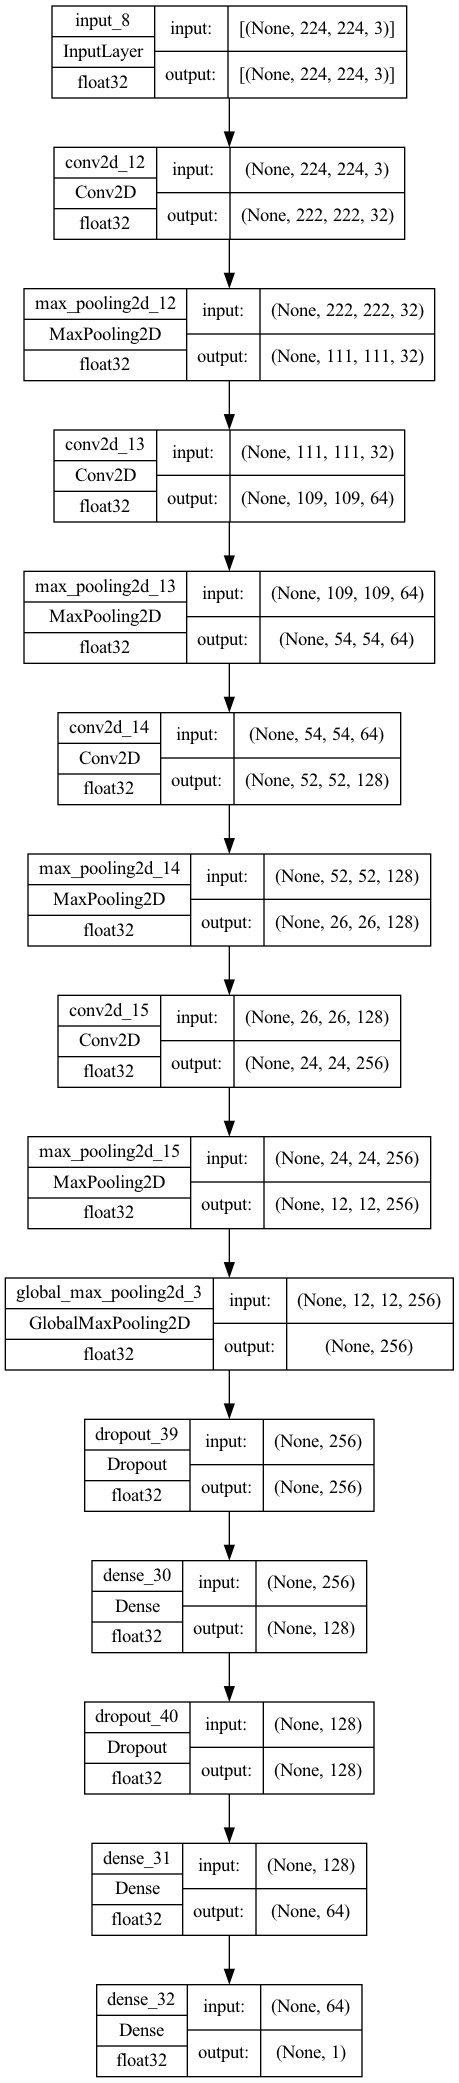

In [377]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(custom_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [314]:
# compile model
custom_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) 

# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_mae', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_mae', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

checkpoint = ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping, checkpoint]

In [315]:
epochs = 30 
custom_model.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks)

Epoch 1/30


2023-04-28 09:26:12.908151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - ETA: 0s - loss: 467.8811 - mae: 16.6850

2023-04-28 09:26:58.101621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 16.53504, saving model to CustomModel.weights.hdf5
494/494 [==============================] - 50s 96ms/step - loss: 467.8811 - mae: 16.6850 - val_loss: 418.3416 - val_mae: 16.5350 - lr: 0.0010
Epoch 2/30
494/494 [==============================] - ETA: 0s - loss: 422.9438 - mae: 15.8779
Epoch 2: val_mae improved from 16.53504 to 16.41605, saving model to CustomModel.weights.hdf5
494/494 [==============================] - 45s 92ms/step - loss: 422.9438 - mae: 15.8779 - val_loss: 404.0142 - val_mae: 16.4160 - lr: 0.0010
Epoch 3/30
494/494 [==============================] - ETA: 0s - loss: 398.8951 - mae: 15.4267
Epoch 3: val_mae improved from 16.41605 to 14.64964, saving model to CustomModel.weights.hdf5
494/494 [==============================] - 46s 92ms/step - loss: 398.8951 - mae: 15.4267 - val_loss: 377.7776 - val_mae: 14.6496 - lr: 0.0010
Epoch 4/30
494/494 [==============================] - ETA: 0s - loss: 376.5752 - mae: 14.9819
Epoch 4: val_m

In [ ]:
test_val_graph (custom_model.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks),'mae','val_mae')

In [317]:
del custom_model

In [318]:
gc.collect()

4565

In [320]:
# import tensorflow as tf
custom_model =  tf.keras.models.load_model('CustomModel.weights.hdf5')

In [321]:
# Evaluate the model 
custom_model.evaluate(test_gen)

2023-04-28 09:49:43.372372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 3s 31ms/step - loss: 103.9018 - mae: 7.1424


[103.90179443359375, 7.142443656921387]

**VGG16 model**

In [254]:
# Import the VGG16 pretrained model 
from tensorflow.keras.applications import VGG16 

vgg16 = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False) 

for i in vgg16.layers[:-3]:
    i.trainable = False 

# build model 
input = vgg16.layers[-1].output # input is the last output from vgg16 

x = Dropout(0.25)(input) 
x = Flatten()(x) 

output = Dense(1, activation='relu')(x) 

# create the model 
vgg16_model = Model(vgg16.input, output, name='VGG16_Model')

In [255]:
vgg16_model.summary()

Model: "VGG16_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [ ]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(vgg16_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [257]:
# compile the model 
import tensorflow as tf
vgg16_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4), loss= 'mse', metrics= ['mae']) 

# reinitialize callbacks 
checkpoint = ModelCheckpoint('VggModel.weights.hdf5', monitor='val_mae', verbose=1,save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping,checkpoint] 

In [258]:
# Train model 
vgg16_model.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks)

Epoch 1/30


2023-04-27 22:05:18.264615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - ETA: 0s - loss: 215.3672 - mae: 11.0135

2023-04-27 22:07:38.627503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 8.07949, saving model to VggModel.weights.hdf5
494/494 [==============================] - 184s 371ms/step - loss: 215.3672 - mae: 11.0135 - val_loss: 116.0702 - val_mae: 8.0795 - lr: 1.0000e-04
Epoch 2/30
494/494 [==============================] - ETA: 0s - loss: 112.9713 - mae: 7.9300
Epoch 2: val_mae improved from 8.07949 to 7.55560, saving model to VggModel.weights.hdf5
494/494 [==============================] - 182s 369ms/step - loss: 112.9713 - mae: 7.9300 - val_loss: 107.4355 - val_mae: 7.5556 - lr: 1.0000e-04
Epoch 3/30
494/494 [==============================] - ETA: 0s - loss: 93.9403 - mae: 7.2083
Epoch 3: val_mae improved from 7.55560 to 7.14881, saving model to VggModel.weights.hdf5
494/494 [==============================] - 182s 369ms/step - loss: 93.9403 - mae: 7.2083 - val_loss: 97.9017 - val_mae: 7.1488 - lr: 1.0000e-04
Epoch 4/30
494/494 [==============================] - ETA: 0s - loss: 83.9376 - mae: 6.8097
Epoch 4: val_mae impro

In [259]:
del vgg16_model

In [260]:
gc.collect()

11492

In [261]:
vgg16_model =  tf.keras.models.load_model('VggModel.weights.hdf5')

In [262]:
# Evaluate the model 
vgg16_model.evaluate(test_gen)

2023-04-27 23:15:33.660150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 19s 252ms/step - loss: 73.7886 - mae: 6.3469


[73.78861999511719, 6.346898078918457]

**MobileNet model**

In [407]:
# initializing the mobilenet model
import tensorflow as tf
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)

# freezing all but the last 5 layers
for layer in mobilenet.layers[:-3]:
  layer.trainable = False

# add few mor layers
x = mobilenet.layers[-1].output
x = Dropout(0.5)(x)
x = Flatten()(x) 
x = Dense(1000, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='relu')(x)

# Create the model
mobilenet_model = Model(mobilenet.input, output, name= "Mobilenet_Model")

In [408]:
mobilenet_model.summary()

Model: "Mobilenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                            

In [ ]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(mobilenet_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [409]:
# compile the model 
mobilenet_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4), loss= 'mse', metrics= ['mae']) 

# reinitialize callbacks 
checkpoint = ModelCheckpoint('MobilenetModel.weights.hdf5', monitor='val_mae', verbose=1,save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping,checkpoint] 

In [410]:
epochs=10
# model training 
mobilenet_model.fit(train_gen, validation_data=test_gen, epochs=epochs, callbacks= callbacks)

Epoch 1/10


2023-04-28 13:17:01.360205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - ETA: 0s - loss: 148.4300 - mae: 9.0231

2023-04-28 13:17:41.825598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 8.19643, saving model to MobilenetModel.weights.hdf5
494/494 [==============================] - 48s 91ms/step - loss: 148.4300 - mae: 9.0231 - val_loss: 109.7656 - val_mae: 8.1964 - lr: 1.0000e-04
Epoch 2/10
494/494 [==============================] - ETA: 0s - loss: 81.6323 - mae: 6.7746
Epoch 2: val_mae improved from 8.19643 to 6.81745, saving model to MobilenetModel.weights.hdf5
494/494 [==============================] - 43s 86ms/step - loss: 81.6323 - mae: 6.7746 - val_loss: 89.0130 - val_mae: 6.8174 - lr: 1.0000e-04
Epoch 3/10
494/494 [==============================] - ETA: 0s - loss: 63.3773 - mae: 6.0142
Epoch 3: val_mae improved from 6.81745 to 6.57229, saving model to MobilenetModel.weights.hdf5
494/494 [==============================] - 42s 85ms/step - loss: 63.3773 - mae: 6.0142 - val_loss: 80.5401 - val_mae: 6.5723 - lr: 1.0000e-04
Epoch 4/10
494/494 [==============================] - ETA: 0s - loss: 48.2288 - mae: 5.2520
Epoch 4: val_m

In [411]:
del mobilenet_model

In [412]:
gc.collect()

7368

In [413]:
mobilenet_model =  tf.keras.models.load_model('MobilenetModel.weights.hdf5')

In [414]:
# Evaluate the model 
mobilenet_model.evaluate(test_gen)

2023-04-28 13:24:16.087182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 6s 61ms/step - loss: 83.0389 - mae: 6.5045


[83.03893280029297, 6.504515171051025]

**Ниже приведены примеры ансамбля моделей. Оставлены только удачные и почти удачные варианты. В них использованы только модели vgg16_model и mobilenet_model, так как оставшиеся 2 моделм (model и custom_model) показали результат ниже и ансамбли с ними не принесли желаемого результата.**

# Средний ансамбль

In [527]:
# create average model

# import average layer
from tensorflow.keras.layers import Average

# freezing all but the last 5 layers in custom_midel
# for layer in custom_model.layers[:-5]:
#   layer.trainable = False

# get list of models
models = [vgg16_model, mobilenet_model] 

input = Input(shape=(224, 224, 3), name='input') # input layer

# get output for each model input
outputs = [model(input) for model in models]

# take average of the outputs
x = Average()(outputs) 

x = Dense(100, activation='relu')(x) 
x = Dropout(0.3)(x) 

output = Dense(1, activation='linear', name='output')(x) # output layer

# create avetage model
avg_model = Model(input, output, name= 'Average_Model')

In [528]:
avg_model.summary()

Model: "Average_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_Model (Functional)       (None, 1)            14739777    ['input[0][0]']                  
                                                                                                  
 Mobilenet_Model (Functional)   (None, 1)            53406865    ['input[0][0]']                  
                                                                                                  
 average_18 (Average)           (None, 1)            0           ['VGG16_Model[25][0]'

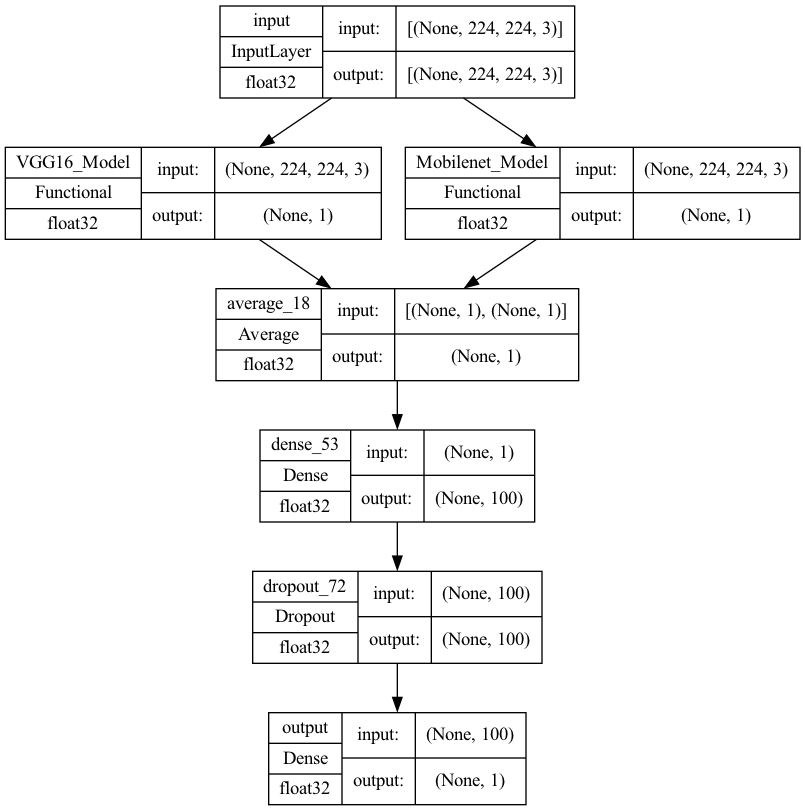

In [529]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(avg_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [531]:
# compile the model 
avg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

In [532]:
# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_mae', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_mae', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

checkpoint = ModelCheckpoint('Avg_Model.h5', monitor='val_mae', verbose=1, save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping, checkpoint]

In [533]:
# train the model
avg_model.fit(train_gen, validation_data=valid_gen, epochs= 20, callbacks= callbacks)

Epoch 1/20


2023-04-28 15:39:50.104525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - ETA: 0s - loss: 1481.9131 - mae: 32.6921

2023-04-28 15:42:50.506233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 32.76030, saving model to Avg_Model.h5
494/494 [==============================] - 238s 473ms/step - loss: 1481.9131 - mae: 32.6921 - val_loss: 1449.1787 - val_mae: 32.7603 - lr: 1.0000e-05
Epoch 2/20
494/494 [==============================] - ETA: 0s - loss: 1131.0951 - mae: 27.5513
Epoch 2: val_mae improved from 32.76030 to 21.74274, saving model to Avg_Model.h5
494/494 [==============================] - 229s 463ms/step - loss: 1131.0951 - mae: 27.5513 - val_loss: 730.3983 - val_mae: 21.7427 - lr: 1.0000e-05
Epoch 3/20
494/494 [==============================] - ETA: 0s - loss: 518.0426 - mae: 16.9423
Epoch 3: val_mae improved from 21.74274 to 11.58558, saving model to Avg_Model.h5
494/494 [==============================] - 228s 462ms/step - loss: 518.0426 - mae: 16.9423 - val_loss: 261.1038 - val_mae: 11.5856 - lr: 1.0000e-05
Epoch 4/20
494/494 [==============================] - ETA: 0s - loss: 240.7169 - mae: 10.8488
Epoch 4: val_mae improved fr

In [534]:
del avg_model

In [535]:
gc.collect()

2429

In [537]:
# load trained model
avg_model = tf.keras.models.load_model('Avg_Model.h5')

In [538]:
# evaluate the model
avg_model.evaluate(test_gen)

2023-04-28 17:52:32.012094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 27s 324ms/step - loss: 76.8227 - mae: 6.3790


[76.82274627685547, 6.379004001617432]

# Ансамбль конкатенации

In [551]:
# concatenate the models

# import concatenate layer
from tensorflow.keras.layers import Concatenate

# # freezing all but the last 5 layers in custom_midel
# for layer in custom_model.layers[:-5]:
#   layer.trainable = True

# # freezing all but the last 5 layers in custom_midel
# for layer in vgg16_model.layers[:-5]:
#   layer.trainable = False

# get list of models
models = [vgg16_model, mobilenet_model] 

input = Input(shape=(224, 224, 3), name='input') # input layer

# get output for each model input
outputs = [model(input) for model in models]

# contenate the ouputs
x = Concatenate()(outputs) 

# add further layers
x = Dense(1000, activation='relu')(x)
x = Dropout(0.25)(x) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.25)(x) 
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x) 

output = Dense(1, activation='linear', name='output')(x) # output layer

# create concatenated model
model_conc = Model(input, output, name= 'Model_conc')

In [552]:
model_conc.summary()

Model: "Model_conc"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_Model (Functional)       (None, 1)            14739777    ['input[0][0]']                  
                                                                                                  
 Mobilenet_Model (Functional)   (None, 1)            53406865    ['input[0][0]']                  
                                                                                                  
 concatenate_53 (Concatenate)   (None, 2)            0           ['VGG16_Model[28][0]',  

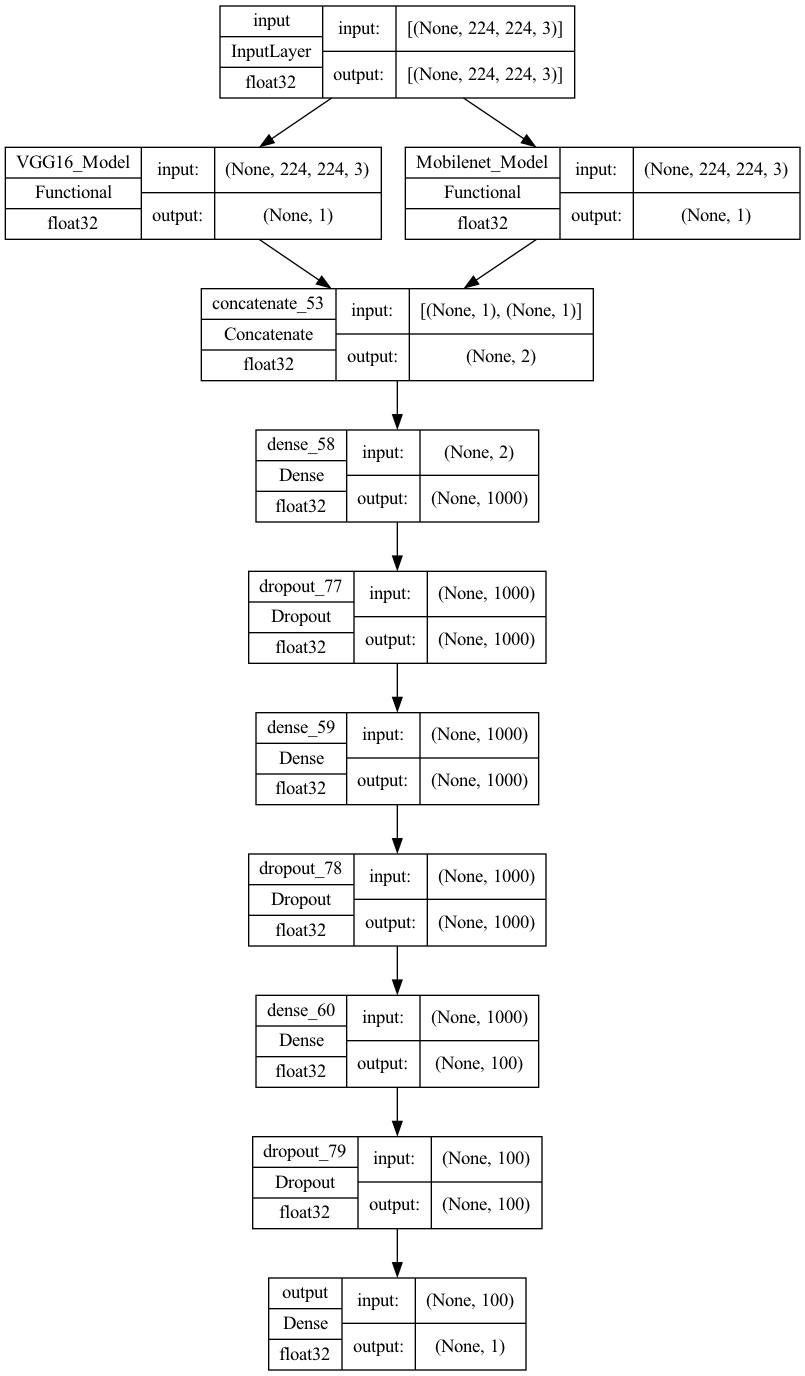

In [553]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(model_conc,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [554]:
# compile the model 
model_conc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss='mse', metrics=['mae'])

In [555]:
# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_mae', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_mae', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

checkpoint = ModelCheckpoint('Model_conc.h5', monitor='val_mae', verbose=1, save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping, checkpoint]

In [556]:
# itrain the model
model_conc.fit(train_gen, validation_data=valid_gen, epochs= 20, callbacks= callbacks)

Epoch 1/20


2023-04-28 20:14:37.965292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - ETA: 0s - loss: 57.6286 - mae: 5.3631

2023-04-28 20:18:03.667077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 6.49640, saving model to Model_conc.h5
494/494 [==============================] - 268s 535ms/step - loss: 57.6286 - mae: 5.3631 - val_loss: 74.4765 - val_mae: 6.4964 - lr: 5.0000e-05
Epoch 2/20
494/494 [==============================] - ETA: 0s - loss: 36.5278 - mae: 4.5649
Epoch 2: val_mae improved from 6.49640 to 6.09113, saving model to Model_conc.h5
494/494 [==============================] - 259s 524ms/step - loss: 36.5278 - mae: 4.5649 - val_loss: 70.5839 - val_mae: 6.0911 - lr: 5.0000e-05
Epoch 3/20
494/494 [==============================] - ETA: 0s - loss: 32.6325 - mae: 4.2962
Epoch 3: val_mae did not improve from 6.09113
494/494 [==============================] - 258s 523ms/step - loss: 32.6325 - mae: 4.2962 - val_loss: 72.1573 - val_mae: 6.2858 - lr: 5.0000e-05
Epoch 4/20
494/494 [==============================] - ETA: 0s - loss: 29.1323 - mae: 4.0946
Epoch 4: val_mae did not improve from 6.09113
494/494 [==============================] 

In [557]:
del model_conc

In [558]:
gc.collect()

852

In [559]:
# load trained model
model_conc = tf.keras.models.load_model('Model_conc.h5')

In [560]:
# evaluate the model
model_conc.evaluate(test_gen)

2023-04-28 20:50:10.224803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 28s 345ms/step - loss: 72.3079 - mae: 6.1858


[72.30791473388672, 6.185770034790039]

# Вывод

| Модель | train | valid | test |
| ----------- | ----------- | ----------- |----------- |
| model | 9,35 | 9,87 | 9,69 | 
| custom_model | 5,23 | 7,09 | 7,14 |
| vgg16_model | 4,37 | 6,29 | 6.34 |
| mobilenet_model | 3,48 | 6,66 | 6.50 |
| avg_model | 4,92 | 6,27 | 6,37 |
| model_conc | 3.49 | 6.15 | 6,18 |

К улучшению результата привела конкатенация моделей, давших примерно одинаковый результат при отдельном обучении.

Средний ансамбль моделей vgg16_model и mobilenet_model не улучшил результат.

Конкатенации моделей vgg16_model и mobilenet_model улучшила результат с 6.34 до 6.18.

Применение ансамбля моделей в примере выше не оправдывает временные затраты. Скорее всего, при подборе параметров можно было повторить результат конкатенации на отдельной модели.